In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt
import time
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import minmax_scale

## <a id="analysis"></a>1) Data Cleaning


In [2]:
ratings_columns = ['user_id', 'movie_id', 'rating', 'timestamp']
movies_columns = ['movie_id', 'title', 'release_date', 'video_release_date',
                  'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation',
                  "Children's", 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
                  'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi',
                  'Thriller', 'War', 'Western']
users_columns = ['user_id', 'age', 'gender', 'occupation', 'zip_code']

ratings = pd.read_csv('/Users/ytuo/Desktop/ml-100k/u.data', sep='\t', names=ratings_columns, encoding='latin-1')
movies = pd.read_csv('/Users/ytuo/Desktop/ml-100k/u.item', sep='|', names=movies_columns, encoding='latin-1', usecols=range(24))
users = pd.read_csv('/Users/ytuo/Desktop/ml-100k/u.user', sep='|', names=users_columns, encoding='latin-1')

In [3]:
# no missing values
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   user_id    100000 non-null  int64
 1   movie_id   100000 non-null  int64
 2   rating     100000 non-null  int64
 3   timestamp  100000 non-null  int64
dtypes: int64(4)
memory usage: 3.1 MB


In [4]:
#'release_date ' and 'IMDb_URL' have missing values. 'video_release_date' isn't usable
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1682 entries, 0 to 1681
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   movie_id            1682 non-null   int64  
 1   title               1682 non-null   object 
 2   release_date        1681 non-null   object 
 3   video_release_date  0 non-null      float64
 4   IMDb_URL            1679 non-null   object 
 5   unknown             1682 non-null   int64  
 6   Action              1682 non-null   int64  
 7   Adventure           1682 non-null   int64  
 8   Animation           1682 non-null   int64  
 9   Children's          1682 non-null   int64  
 10  Comedy              1682 non-null   int64  
 11  Crime               1682 non-null   int64  
 12  Documentary         1682 non-null   int64  
 13  Drama               1682 non-null   int64  
 14  Fantasy             1682 non-null   int64  
 15  Film-Noir           1682 non-null   int64  
 16  Horror

In [5]:
# no missing values
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 943 entries, 0 to 942
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     943 non-null    int64 
 1   age         943 non-null    int64 
 2   gender      943 non-null    object
 3   occupation  943 non-null    object
 4   zip_code    943 non-null    object
dtypes: int64(2), object(3)
memory usage: 37.0+ KB


In [6]:
#data cleaning
movies['release_year'] = pd.to_datetime(movies['release_date'], errors='coerce').dt.year
movies.drop(columns=['release_date', 'video_release_date','IMDb_URL'], inplace=True)  

media_date = movies['release_year'].median() 
movies['release_year'].fillna(media_date, inplace=True)


/var/folders/1m/q5sjtn1j2vl7qtygfw9p_9680000gn/T/ipykernel_91173/1820046281.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  movies['release_year'].fillna(media_date, inplace=True)


In [7]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1682 entries, 0 to 1681
Data columns (total 22 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   movie_id      1682 non-null   int64  
 1   title         1682 non-null   object 
 2   unknown       1682 non-null   int64  
 3   Action        1682 non-null   int64  
 4   Adventure     1682 non-null   int64  
 5   Animation     1682 non-null   int64  
 6   Children's    1682 non-null   int64  
 7   Comedy        1682 non-null   int64  
 8   Crime         1682 non-null   int64  
 9   Documentary   1682 non-null   int64  
 10  Drama         1682 non-null   int64  
 11  Fantasy       1682 non-null   int64  
 12  Film-Noir     1682 non-null   int64  
 13  Horror        1682 non-null   int64  
 14  Musical       1682 non-null   int64  
 15  Mystery       1682 non-null   int64  
 16  Romance       1682 non-null   int64  
 17  Sci-Fi        1682 non-null   int64  
 18  Thriller      1682 non-null 

In [8]:
print(ratings.head())

   user_id  movie_id  rating  timestamp
0      196       242       3  881250949
1      186       302       3  891717742
2       22       377       1  878887116
3      244        51       2  880606923
4      166       346       1  886397596


In [9]:
print(ratings.describe())

            user_id       movie_id         rating     timestamp
count  100000.00000  100000.000000  100000.000000  1.000000e+05
mean      462.48475     425.530130       3.529860  8.835289e+08
std       266.61442     330.798356       1.125674  5.343856e+06
min         1.00000       1.000000       1.000000  8.747247e+08
25%       254.00000     175.000000       3.000000  8.794487e+08
50%       447.00000     322.000000       4.000000  8.828269e+08
75%       682.00000     631.000000       4.000000  8.882600e+08
max       943.00000    1682.000000       5.000000  8.932866e+08


In [10]:
print(movies.head())

   movie_id              title  unknown  Action  Adventure  Animation  \
0         1   Toy Story (1995)        0       0          0          1   
1         2   GoldenEye (1995)        0       1          1          0   
2         3  Four Rooms (1995)        0       0          0          0   
3         4  Get Shorty (1995)        0       1          0          0   
4         5     Copycat (1995)        0       0          0          0   

   Children's  Comedy  Crime  Documentary  ...  Film-Noir  Horror  Musical  \
0           1       1      0            0  ...          0       0        0   
1           0       0      0            0  ...          0       0        0   
2           0       0      0            0  ...          0       0        0   
3           0       1      0            0  ...          0       0        0   
4           0       0      1            0  ...          0       0        0   

   Mystery  Romance  Sci-Fi  Thriller  War  Western  release_year  
0        0        0     

In [11]:
print(movies.describe())

          movie_id      unknown       Action    Adventure    Animation  \
count  1682.000000  1682.000000  1682.000000  1682.000000  1682.000000   
mean    841.500000     0.001189     0.149227     0.080262     0.024970   
std     485.695893     0.034473     0.356418     0.271779     0.156081   
min       1.000000     0.000000     0.000000     0.000000     0.000000   
25%     421.250000     0.000000     0.000000     0.000000     0.000000   
50%     841.500000     0.000000     0.000000     0.000000     0.000000   
75%    1261.750000     0.000000     0.000000     0.000000     0.000000   
max    1682.000000     1.000000     1.000000     1.000000     1.000000   

        Children's       Comedy        Crime  Documentary        Drama  ...  \
count  1682.000000  1682.000000  1682.000000  1682.000000  1682.000000  ...   
mean      0.072533     0.300238     0.064804     0.029727     0.431034  ...   
std       0.259445     0.458498     0.246253     0.169882     0.495368  ...   
min       0.00000

In [12]:
print(users.head())

   user_id  age gender  occupation zip_code
0        1   24      M  technician    85711
1        2   53      F       other    94043
2        3   23      M      writer    32067
3        4   24      M  technician    43537
4        5   33      F       other    15213


In [13]:
print(users.describe())

          user_id         age
count  943.000000  943.000000
mean   472.000000   34.051962
std    272.364951   12.192740
min      1.000000    7.000000
25%    236.500000   25.000000
50%    472.000000   31.000000
75%    707.500000   43.000000
max    943.000000   73.000000


## <a id="analysis"></a>2) Exploratory Data Analysis 

This section will delve into data exploration and visualization techniques to scrutinize the processed datasets thoroughly.<br>

### <a id="users"></a>2.1) Users Dataset Exploration

In [14]:
user_age_gender_data = users[['gender', 'age']]

# Filtering by gender
female_user_ages = user_age_gender_data[user_age_gender_data['gender'] == 'F'].sort_values('age')
male_user_ages = user_age_gender_data[user_age_gender_data['gender'] == 'M'].sort_values('age')

def get_group_count(min_age, max_age, dataset):
    # Applying the age group criteria
    age_group = dataset.apply(lambda x: True if max_age >= x['age'] > min_age else False, axis=1)
    count = len(age_group[age_group == True].index)
    return count

# Male age groups
G1_male = get_group_count(0, 18, male_user_ages)
G2_male = get_group_count(18, 25, male_user_ages)
G3_male = get_group_count(25, 35, male_user_ages)
G4_male = get_group_count(35, 45, male_user_ages)
G5_male = get_group_count(45, 50, male_user_ages)
G6_male = get_group_count(50, 56, male_user_ages)
G7_male = get_group_count(56, 200, male_user_ages)

# Female age groups
G1_female = get_group_count(0, 18, female_user_ages)
G2_female = get_group_count(18, 25, female_user_ages)
G3_female = get_group_count(25, 35, female_user_ages)
G4_female = get_group_count(35, 45, female_user_ages)
G5_female = get_group_count(45, 50, female_user_ages)
G6_female = get_group_count(50, 56, female_user_ages)
G7_female = get_group_count(56, 200, female_user_ages)

# Organizing the counts into a structured format for better interpretation
age_group_counts = {
    'Age Group': ['0-18', '19-25', '26-35', '36-45', '46-50', '51-55', '56+'],
    'Male': [G1_male, G2_male, G3_male, G4_male, G5_male, G6_male, G7_male],
    'Female': [G1_female, G2_female, G3_female, G4_female, G5_female, G6_female, G7_female]
}

age_group_counts_df = pd.DataFrame(age_group_counts)
age_group_counts_df


,Age Group,Male,Female
0,0-18,30,24
1,19-25,166,52
2,26-35,217,82
3,36-45,122,60
4,46-50,55,30
5,51-55,39,20
6,56+,41,5


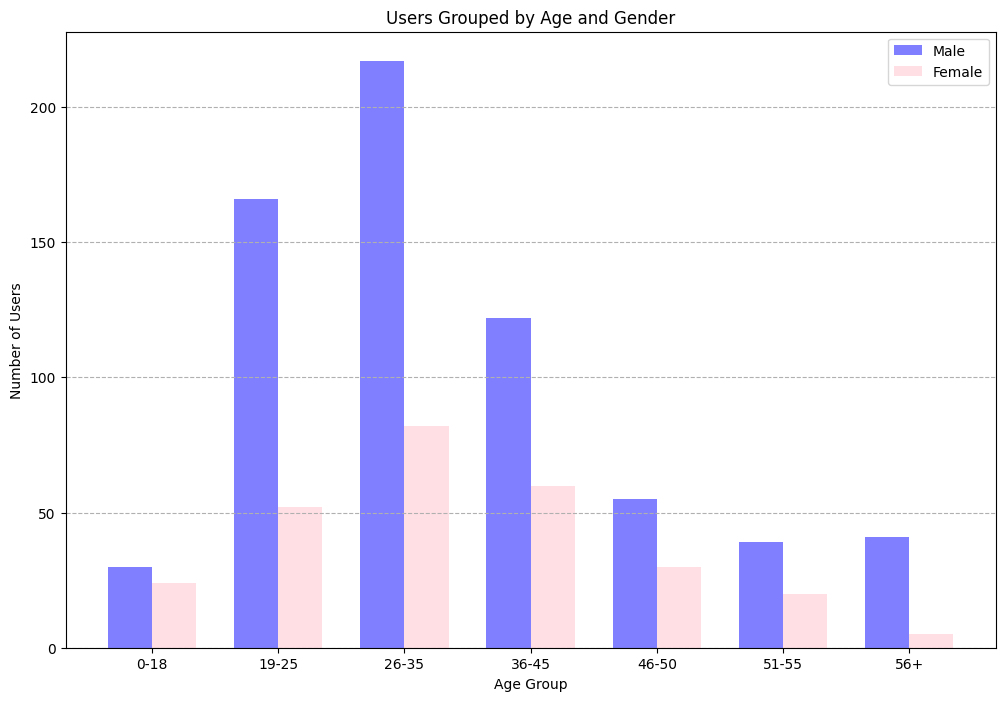

In [15]:
fig, ax = plt.subplots(figsize=(12, 8))

positions = list(range(len(age_group_counts_df['Age Group'])))
width = 0.35

# Plotting bars for male and female counts in each age group
plt.bar([p - width/2 for p in positions], age_group_counts_df['Male'], width, alpha=0.5, label='Male', color='blue')
plt.bar([p + width/2 for p in positions], age_group_counts_df['Female'], width, alpha=0.5, label='Female', color='pink')

ax.set_xticks(positions)
ax.set_xticklabels(age_group_counts_df['Age Group'])
plt.xlabel('Age Group')
plt.ylabel('Number of Users')
plt.title('Users Grouped by Age and Gender')
plt.legend()
plt.grid(axis='y', linestyle='--')
plt.show()

- The age group with the highest number of users is 26-35, followed by 19-25, suggesting that the user base is predominantly young adults.
- In every age group, there are more male users than female users.
- The difference in the number of users between genders is greatest in the 26-35 age group.
- The number of users tends to decrease as age increases, with the 56+ age group having the fewest users.

### <a id="movies-ratings"></a>2.2)  the Movies and Ratings Datasets Exploration

In [16]:
genres = ['Action', 'Adventure', 'Animation', "Children's", 'Comedy', 'Crime', 'Documentary', 'Drama', 
          'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 
          'War', 'Western']

# Merging the ratings and movies dataframes on the movie ID
merged = pd.merge(ratings, movies, left_on='movie_id', right_on='movie_id')

# Selecting necessary columns
cleaned = merged[['movie_id', 'user_id', 'rating', *genres, 'title']]

# Initializing the list for storing genres rating count
genres_rating_count = []

# Looping through each genre and rating to count the occurrences
rating_scale = [1, 2, 3, 4, 5]
for genre in genres:
    for rating in rating_scale:
        genre_list = cleaned.loc[cleaned[genre] == 1]
        genre_rated_count = len(genre_list.loc[genre_list['rating'] == rating])
        genres_rating_count.append([genre, rating, genre_rated_count])

# Functions to calculate the count of specific ratings and total ratings for genres
def get_rating_count(score):
    rating_count = [0] * len(genres)
    for i, count in enumerate(genres_rating_count):
        if count[1] == score:
            genre_index = i // 5  
            rating_count[genre_index] += count[2]
    return rating_count

def get_total_rating_count():
    totals = [0] * len(genres)
    for i, count in enumerate(genres_rating_count):
        genre_index = i // 5
        totals[genre_index] += count[2]
    return totals


genre_df = pd.DataFrame({
    'Genre': genres,
    'Rated 1': get_rating_count(1),
    'Rated 2': get_rating_count(2),
    'Rated 3': get_rating_count(3),
    'Rated 4': get_rating_count(4),
    'Rated 5': get_rating_count(5),
})

# Adding total number of ratings and calculating average rating for each genre
genre_df['Total nr of ratings'] = get_total_rating_count()
genre_df['Average rating'] = genre_df.apply(lambda row: sum([(i+1) * row[f'Rated {i+1}'] for i in range(5)]) / row['Total nr of ratings'], axis=1)

# Displaying the DataFrame
print(genre_df)


          Genre  Rated 1  Rated 2  Rated 3  Rated 4  Rated 5  \
0        Action     1547     3254     7254     8431     5103   
1     Adventure      804     1709     3901     4436     2903   
2     Animation      186      373     1018     1232      796   
3    Children's      574      961     2218     2212     1217   
4        Comedy     2279     3856     8751     9722     5224   
5         Crime      417      834     2006     2835     1963   
6   Documentary       59       58      164      268      209   
7         Drama     1766     3647     9877    14608     9997   
8       Fantasy      112      220      461      383      176   
9     Film-Noir       45       97      367      664      560   
10       Horror      503      814     1513     1610      877   
11      Musical      285      574     1418     1627     1050   
12      Mystery      255      526     1306     1933     1225   
13      Romance      942     2017     5061     6882     4559   
14       Sci-Fi      724     1519     32

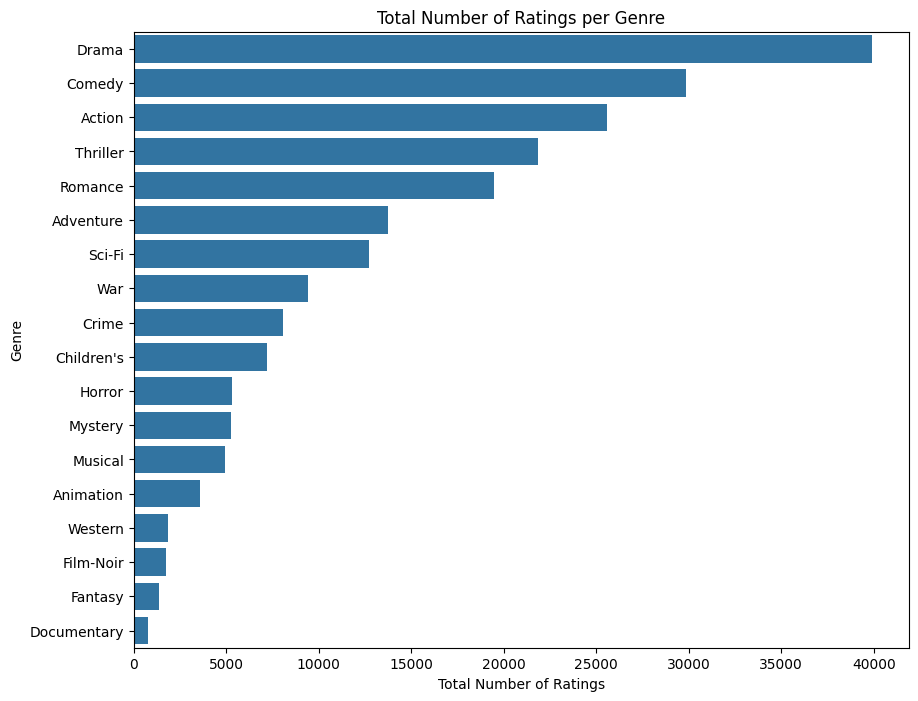

In [17]:
genre_df_sorted = genre_df.sort_values('Total nr of ratings', ascending=False)
genre_df_melted_sorted = genre_df_sorted.melt(id_vars=['Genre'], value_vars=['Rated 1', 'Rated 2', 'Rated 3', 'Rated 4', 'Rated 5'],
                                              var_name='Rating Score', value_name='Count')

# Total Number of Ratings per Genre
plt.figure(figsize=(10, 8))
sns.barplot(data=genre_df_sorted, y='Genre', x='Total nr of ratings', orient='h')
plt.title('Total Number of Ratings per Genre')
plt.ylabel('Genre')
plt.xlabel('Total Number of Ratings')
plt.show()

The chart demonstrates clear preferences in movie genres among users, with Drama being the most popular for ratings, indicating either a higher number of Drama movies in the dataset or a greater interest in this genre among the users rating the movies.

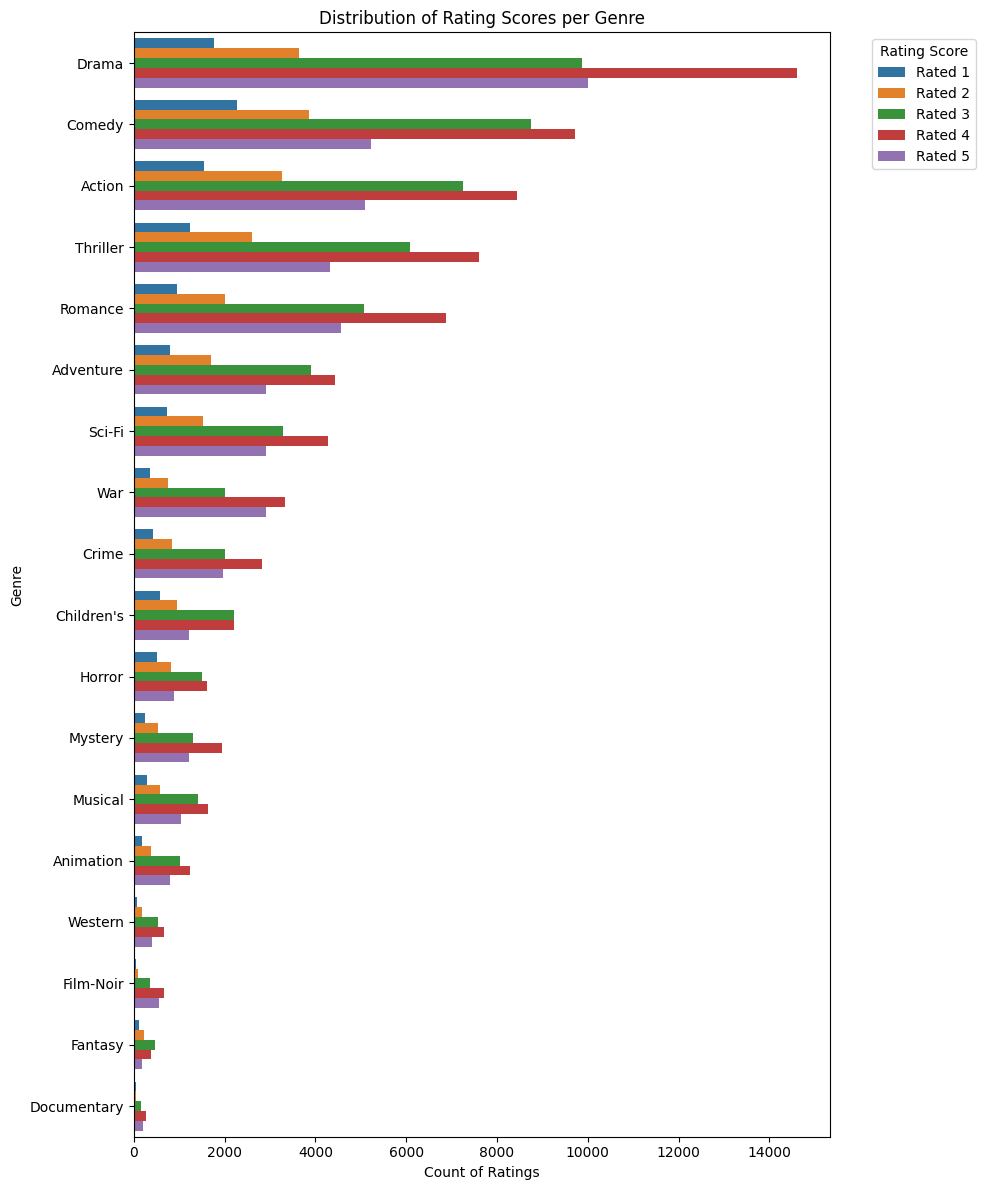

In [18]:
# Distribution of Rating Scores per Genre
plt.figure(figsize=(10, 12))
sns.barplot(data=genre_df_melted_sorted, y='Genre', x='Count', hue='Rating Score', orient='h', order=genre_df_sorted['Genre'])
plt.title('Distribution of Rating Scores per Genre')
plt.ylabel('Genre')
plt.xlabel('Count of Ratings')
plt.legend(title='Rating Score', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

 Drama, Comedy, and Action are the most frequently rated genres, with Drama at the top. Most ratings across all genres are 3 or above, indicating that users tend to rate movies positively.

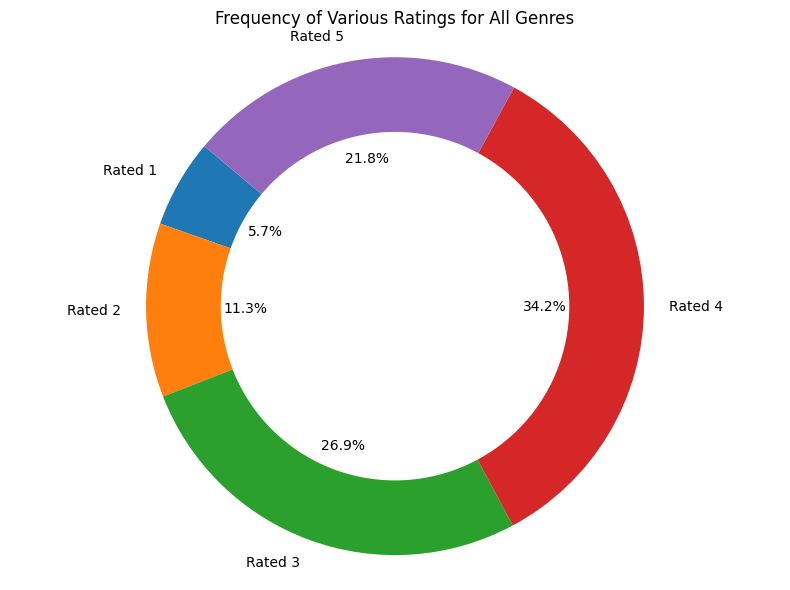

In [19]:
total_ratings = genre_df_sorted[['Rated 1', 'Rated 2', 'Rated 3', 'Rated 4', 'Rated 5']].sum()

# Create a doughnut chart using matplotlib and seaborn
plt.figure(figsize=(8, 6))
plt.pie(total_ratings, labels=total_ratings.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('tab10'))
plt.title('Frequency of Various Ratings for All Genres')
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.axis('equal')  # Equal aspect ratio ensures that pie chart is drawn as a circle.
plt.tight_layout()
plt.show()

most movie ratings are 4 or 5, indicating people often rate movies highly. Fewer ratings are 1 or 2, showing that people rarely give the lowest scores.

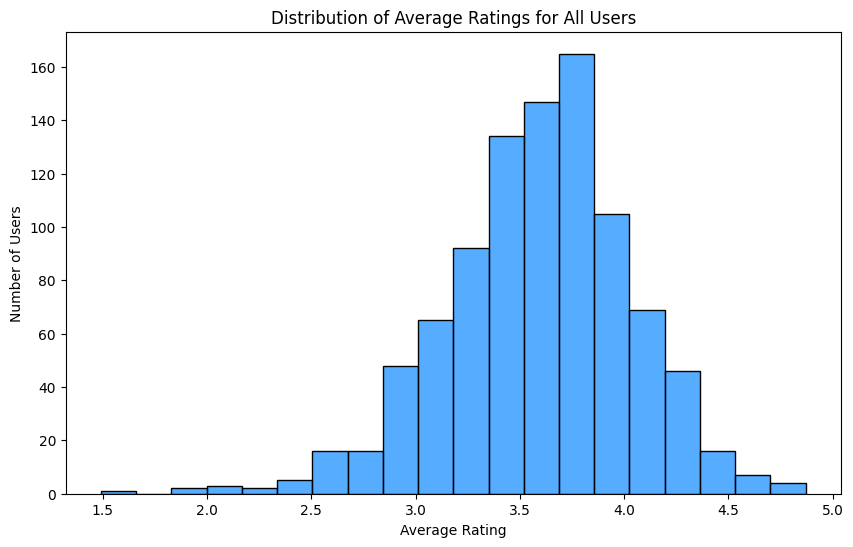

In [20]:
# Calculate the average rating for each user
user_avg_ratings = ratings.groupby('user_id')['rating'].mean()

# Plot the distribution of average ratings for all users
plt.figure(figsize=(10, 6))
sns.histplot(user_avg_ratings, bins=20, kde=False, color='dodgerblue')
plt.title('Distribution of Average Ratings for All Users')
plt.xlabel('Average Rating')
plt.ylabel('Number of Users')
plt.show()


Most users have an average rating between 3 and 4, with the highest number of users around 3.5 to 4. There are very few users with an average rating below 2.5 or above 4.5. This suggests that users generally give moderate to high ratings, and very high or very low average ratings are uncommon.

## <a id="1st-iteration"></a>3) Building a Hybrid Recommender System with CBF and CF models


### <a id="splitting-the-dataset"></a>3.1) Splitting the Dataset


I've opted for a 70% training, 15% validation, and 15% test split as I prioritize a larger training set despite the trade-off of having smaller validation and test sets. I believe the reduction in size for validation and testing will not compromise the models' ability to generalize, given the simplicity of the machine learning models and the limited number of hyperparameters involved.

In [21]:
X = ratings.drop(columns='rating')
y = ratings['rating'].values 

# Splitting the data into train, validation, and test sets with a 70%, 15%, 15% split.
X_train, X_val_and_test, y_train, y_val_and_test = train_test_split(X, y, test_size=0.3, random_state=101)
X_val, X_test, y_val, y_test = train_test_split(X_val_and_test, y_val_and_test, test_size=0.5, random_state=101)

train_df = X_train.copy()
train_df['rating'] = y_train



In [22]:
train_df

,user_id,movie_id,timestamp,rating
64304,885,866,885713102,3
78145,104,222,888465319,3
19755,82,174,878769478,5
78591,450,597,882473914,4
42070,373,1066,877106233,4
...,...,...,...,...
5695,94,385,891721975,2
73542,537,39,886031407,2
83281,399,1,882340657,4
83467,303,631,879483617,4


In [23]:
# Calculate the average rating for each movie
movie_averages = ratings.groupby('movie_id')['rating'].mean()

# For simplicity in this baseline model, we predict that every user rates every movie with the movie's average rating
# We will simulate this by creating a new column in the 'ratings' 
ratings['predicted_rating'] = ratings['movie_id'].apply(lambda x: movie_averages.get(x, 0))

rmse_baseline = sqrt(mean_squared_error(ratings['rating'], ratings['predicted_rating']))

print(f'The RMSE of the baseline model is: {rmse_baseline}')

The RMSE of the baseline model is: 1.000070019527579


### <a id="splitting-the-dataset"></a>3.2) CBF
In this study, the focus is on leveraging content-based filtering (CBF) models for movie recommendations, utilizing user ratings and movie genres to tailor individual models for each user. These models aim to predict ratings for unseen movies by each user, based on their historical preferences. A variety of machine learning algorithms will be explored to identify the most effective for content-based recommendations within this dataset. Despite an inclination towards linear models potentially offering superior performance, the exploration will include diverse algorithm types to broaden learning.

The primary strength of CBF lies in its personalized approach, considering individual user preferences, which aligns well with the nature of movie recommendations. Users typically favor certain genres, actors, or directors, making CBF a suitable method. However, the MovieLens dataset presents challenges due to its limited movie features, essential for accurately modeling user preferences. 

One notable drawback of CBF is its difficulty in handling sparse matrices, a likely encounter given the tendency of users to rate only a small subset of movies. Additionally, unlike collaborative filtering, CBF does not account for user similarities, focusing solely on the content and individual user profiles.

The hypothesis posits that a CBF model, relying solely on movie genre and user data, may fall short of surpassing the baseline model due to the dataset's feature limitations. Despite this, the endeavor aims to gauge the efficacy of different models and how closely they can approach or potentially exceed baseline performance. The most effective model will subsequently be integrated into the hybrid recommender system.

#### <a id="splitting-the-dataset"></a>3.2.1) Data Processing for CBF

In [24]:
content_train_df = pd.merge(train_df, movies, on='movie_id')
# Drop columns that are not useful for the CBF model
content_train_df.drop(columns=['timestamp', 'movie_id', 'title'], inplace=True)

content_train_df

,user_id,rating,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,...,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,release_year
0,885,3,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,1996.0
1,104,3,0,1,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1996.0
2,82,5,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1981.0
3,450,4,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1996.0
4,373,4,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1995.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,94,2,0,1,1,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,1994.0
69996,537,2,0,1,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,1995.0
69997,399,4,0,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,1995.0
69998,303,4,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,1992.0


In [25]:
# Grouping the ratings by user ID
y_grouped_by_user = content_train_df.groupby('user_id')  

# Creating a list of lists with the target attribute (movie ratings), grouped by user ID
y_train_listed = [group['rating'].values for _, group in y_grouped_by_user]  


# Displaying target attributes for the first user in the list
y_train_listed[0]

array([4, 3, 2, 5, 3, 5, 3, 1, 4, 1, 5, 4, 3, 1, 5, 3, 5, 1, 2, 5, 5, 1,
       5, 1, 4, 3, 2, 5, 4, 2, 4, 2, 4, 1, 1, 4, 1, 1, 4, 4, 3, 3, 2, 5,
       5, 5, 4, 1, 5, 4, 3, 5, 3, 5, 4, 3, 3, 5, 4, 4, 3, 5, 1, 4, 4, 5,
       4, 2, 3, 5, 4, 2, 4, 3, 4, 4, 5, 4, 1, 3, 4, 5, 4, 4, 4, 3, 3, 5,
       5, 3, 2, 4, 5, 2, 1, 3, 4, 4, 4, 3, 5, 3, 5, 3, 2, 5, 2, 4, 5, 3,
       4, 3, 5, 5, 5, 4, 4, 3, 4, 5, 4, 1, 5, 5, 2, 4, 4, 3, 3, 5, 5, 3,
       5, 3, 4, 1, 2, 5, 3, 5, 3, 3, 4, 3, 5, 2, 5, 4, 4, 4, 3, 2, 4, 5,
       4, 3, 4, 1, 1, 4, 4, 5, 4, 1, 4, 5, 5, 5, 5, 4, 4, 2, 4, 1, 4, 4,
       3, 4, 4, 4, 4, 2, 3])

In [26]:

content_train_df.drop(columns='rating', inplace=True)  
x_grouped_by_user = content_train_df.groupby('user_id')  
# Create a list of DataFrames with the features for each user
x_train_listed = [group.drop(columns='user_id') for _, group in x_grouped_by_user]

x_train_listed[0]


,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,release_year
426,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1992.0
466,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1987.0
1044,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1995.0
1049,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1995.0
1934,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1995.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68168,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,1994.0
68552,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1981.0
68774,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1994.0
69354,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1995.0


In [27]:
# Creating a new dataframe for the movies data
all_movies = movies.drop(columns=['title', 'movie_id'])
all_movies

,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,release_year
0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1995.0
1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1995.0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1995.0
3,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1995.0
4,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1995.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1677,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1998.0
1678,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1998.0
1679,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1998.0
1680,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1994.0


In [28]:
# Creating the user IDs list from the x_grouped_by_user
user_ids = [user_id for user_id, _ in x_grouped_by_user]


movie_ids = movies["movie_id"].values  

# Creating the matrix. Axis 1: User IDs, Axis 2: Movie IDs. Elements: True ratings from validation data
df_val = X_val.copy()
df_val["rating"] = y_val  
validation_matrix = pd.DataFrame(index=user_ids, columns=movie_ids, dtype=float)  
# Filling in the true ratings as elements
for index, row in df_val.iterrows():
    user = row['user_id']  
    movie = row['movie_id']  
    true_rating = row['rating']      
    validation_matrix.at[user, movie] = true_rating


validation_matrix

,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
1,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
940,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
941,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
942,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### <a id="splitting-the-dataset"></a>3.2.2) Create The Model of CBF

In [29]:
ml_algorithms = {
    "Linear regression": LinearRegression(),
    "Lasso": Lasso(alpha=1.0, max_iter=10000),
    "KNN_7": KNeighborsRegressor(n_neighbors=7),
    "RFR": RandomForestRegressor(n_estimators=1000, n_jobs=3, max_features="sqrt", random_state=0),
    "SVR": SVR(C=1.0)
}

CBF_models_listed = []
RMSE_CBF_listed = []

# Training and predictions
for name, ml_alg in ml_algorithms.items():
    CBF_predictions = []

    for i, x in enumerate(x_train_listed):
        # Fit the model to the current user's training data, now potentially including 'release_year'
        ml_alg.fit(x_train_listed[i], y_train_listed[i])

        # Predict ratings for all movies for the current user, using features that include 'release_year'
        prediction = ml_alg.predict(all_movies)
        prediction = np.clip(prediction, 1, 5)  # Ensure predictions are within the rating scale
        CBF_predictions.append(prediction)

    # Create a dataframe for predictions with users as rows and movies as columns
    df_predict = pd.DataFrame(CBF_predictions, index=user_ids, columns=movie_ids)

    # Calculate RMSE for the current algorithm using validation data
    num_actual = validation_matrix.to_numpy().flatten()[validation_matrix.notna().to_numpy().flatten()]
    num_predict = df_predict.to_numpy().flatten()[validation_matrix.notna().to_numpy().flatten()]
    RMSE_CBF = sqrt(mean_squared_error(num_predict, num_actual))

    CBF_models_listed.append(name)
    RMSE_CBF_listed.append(RMSE_CBF)

# Summarize results
RMSE_CBF_df = pd.DataFrame({"Model": CBF_models_listed, "RMSE": RMSE_CBF_listed})
print(RMSE_CBF_df)

               Model      RMSE
0  Linear regression  1.111007
1              Lasso  1.024088
2              KNN_7  1.039297
3                RFR  1.054727
4                SVR  1.076576


Lasso demonstrated a significantly lower RMSE compared to other models, outshining both linear models and the KNN classifier, which did not surpass the baseline model. Consequently, Lasso will be employed for the hybrid recommender.

In [30]:
# Running the best content-based filtering model so far
model = Lasso(alpha=1.0, max_iter=10000)
CBF_predictions = []

# For each user in the training dataset:
for i, j in enumerate(x_train_listed):
    model.fit(x_train_listed[i], y_train_listed[i])
    prediction = model.predict(all_movies)
    prediction = np.clip(prediction, 1, 5)
    CBF_predictions.append(prediction)

CBF_model = pd.DataFrame(CBF_predictions, index=user_ids, columns=movie_ids)

In [31]:
CBF_model

,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
1,3.524590,3.524590,3.524590,3.524590,3.524590,3.524590,3.524590,3.524590,3.524590,3.524590,...,3.524590,3.524590,3.524590,3.524590,3.524590,3.524590,3.524590,3.524590,3.524590,3.524590
2,3.692308,3.692308,3.692308,3.692308,3.692308,3.692308,3.692308,3.692308,3.692308,3.692308,...,3.692308,3.692308,3.692308,3.692308,3.692308,3.692308,3.692308,3.692308,3.692308,3.692308
3,2.891892,2.891892,2.891892,2.891892,2.891892,2.891892,2.891892,2.891892,2.891892,2.891892,...,2.891892,2.891892,2.891892,2.891892,2.891892,2.891892,2.891892,2.891892,2.891892,2.891892
4,4.411765,4.411765,4.411765,4.411765,4.411765,4.411765,4.411765,4.411765,4.411765,4.411765,...,4.411765,4.411765,4.411765,4.411765,4.411765,4.411765,4.411765,4.411765,4.411765,4.411765
5,2.728526,2.728526,2.728526,2.728526,2.728526,2.728526,2.728526,2.728526,2.728526,2.712936,...,2.728526,3.242989,2.712936,2.712936,2.712936,2.681757,2.681757,2.681757,2.744116,2.712936
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,4.172414,4.172414,4.172414,4.172414,4.172414,4.172414,4.172414,4.172414,4.172414,4.172414,...,4.172414,4.172414,4.172414,4.172414,4.172414,4.172414,4.172414,4.172414,4.172414,4.172414
940,3.390850,3.390850,3.390850,3.390850,3.390850,3.390850,3.390850,3.390850,3.390850,3.389217,...,3.390850,3.444731,3.389217,3.389217,3.389217,3.385952,3.385952,3.385952,3.392483,3.389217
941,4.187500,4.187500,4.187500,4.187500,4.187500,4.187500,4.187500,4.187500,4.187500,4.187500,...,4.187500,4.187500,4.187500,4.187500,4.187500,4.187500,4.187500,4.187500,4.187500,4.187500
942,4.165172,4.165172,4.165172,4.165172,4.165172,4.165172,4.165172,4.165172,4.165172,4.155096,...,4.165172,4.497697,4.155096,4.155096,4.155096,4.134943,4.134943,4.134943,4.175249,4.155096


### <a id="splitting-the-dataset"></a>3.3) CF
Moving forward with the development of collaborative filtering (CF) models, the focus shifts towards implementing a user-based CF approach using the K-Nearest Neighbours (KNN) algorithm. This approach is designed to make recommendations based on the movie preferences of the most similar users, without considering user demographic data such as age, gender, or location. The CF models rely solely on the relationship between users and their movie ratings, focusing on identifying similar tastes among users to predict ratings for movies not yet seen by a given user.

A key methodological aspect involves normalizing the ratings by subtracting each user's mean rating from their ratings of all movies. This adjustment addresses the variance in rating scales among users, acknowledging that individuals may rate similarly appreciated movies differently due to personal rating biases. Similarity between users is quantified using the Pearson correlation coefficient, subtracted from 1, to calculate the relative distances and similarities in movie preferences.

To refine the predictive accuracy of models with higher K values, the implementation includes a weighted average calculation for predicted ratings, where weights are inversely proportional to the Pearson distance. This adjustment aims to enhance prediction quality by giving greater influence to ratings from users most closely aligned in movie preferences.

As with the exploration of content-based filtering models, a variety of CF models will be evaluated, differing primarily in their hyperparameter configurations rather than underlying algorithms. The objective remains to identify the CF model that demonstrates the highest performance, which will then be integrated into the hybrid recommender system outlined in the subsequent section. This approach not only aims to complement the limitations of content-based models but also to potentially surpass their effectiveness through the strategic application of user-based collaborative filtering principles.

#### <a id="splitting-the-dataset"></a>3.3.1) Data Processing for CF

In [32]:
# DATA PREPROCESSING: Calculating the Pearson Distance between all users in the training data
# Creating a 2D matrix (user ID vs movie ID) with the ratings as elements
user_matrix = train_df.pivot(index='user_id', columns='movie_id', values='rating')

# Subtract each user's average rating to magnify individual preferences
user_matrix = user_matrix.sub(user_matrix.mean(axis=1), axis=0)

# Replace NaN with 0.0,
user_matrix = user_matrix.fillna(0.0)
user_matrix

movie_id,1,2,3,4,5,6,7,8,9,10,...,1664,1665,1666,1669,1672,1673,1676,1677,1680,1682
user_id,,,,,,,,,,,,,,,,,,,,,
1,1.475410,-0.524590,0.0,0.0,-0.52459,1.47541,0.475410,-2.524590,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.307692,0.000000,0.0,0.0,0.00000,0.00000,0.000000,0.000000,0.000000,-1.692308,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.000000,0.0,0.0,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.000000,0.0,0.0,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1.139344,0.139344,0.0,0.0,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,0.000000,0.000000,0.0,0.0,0.00000,0.00000,0.000000,0.000000,0.827586,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
940,0.000000,0.000000,0.0,0.0,0.00000,0.00000,0.597403,1.597403,-0.402597,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
941,0.812500,0.000000,0.0,0.0,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
# Pearson Correlation Coefficient matrix among users
pearson_corr = user_matrix.T.corr(method='pearson')
# Convert to Pearson Distance
pearson_distance = 1 - pearson_corr

pearson_distance


user_id,1,2,3,4,5,6,7,8,9,10,...,934,935,936,937,938,939,940,941,942,943
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.000000,0.990932,0.983601,0.974192,0.880702,0.928935,0.940429,0.888861,0.973443,0.999308,...,0.976684,1.049542,0.950204,0.987495,0.952710,0.910457,0.970086,0.940692,1.021715,0.967492
2,0.990932,0.000000,1.000137,1.017072,0.996213,0.991272,0.985587,1.000000,1.000000,0.985836,...,1.028439,0.972019,0.973335,0.941750,0.997112,0.960806,1.001575,0.988834,1.002244,0.999895
3,0.983601,1.000137,0.000000,1.163038,0.977361,1.014321,0.998548,1.000000,1.000000,1.006808,...,0.999045,1.000000,0.981891,0.981047,1.017699,1.000000,1.025988,0.957846,1.060910,0.993323
4,0.974192,1.017072,1.163038,0.000000,1.000000,1.061840,1.007456,0.884414,0.995155,1.030824,...,0.996689,1.000000,1.011328,1.060084,1.007337,1.000000,0.757811,0.618507,0.933035,1.000000
5,0.880702,0.996213,0.977361,1.000000,0.000000,0.969357,0.971233,0.896010,1.000000,0.965069,...,0.981033,1.064908,0.977325,0.949708,0.956630,0.959417,0.928826,0.914398,0.952458,0.952789
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,0.910457,0.960806,1.000000,1.000000,0.959417,1.042544,1.014209,1.000000,1.000000,1.009971,...,1.010514,0.956482,0.940804,1.047040,0.982153,0.000000,0.980408,1.008015,1.034893,1.002011
940,0.970086,1.001575,1.025988,0.757811,0.928826,1.032596,0.999276,0.926527,0.985135,1.011421,...,1.021424,0.949841,1.025664,1.029261,1.028286,0.980408,0.000000,0.860681,0.982383,0.980355
941,0.940692,0.988834,0.957846,0.618507,0.914398,1.005553,0.994422,0.850988,1.001645,0.977102,...,1.039364,1.081855,0.948709,0.928493,1.097507,1.008015,0.860681,0.000000,1.031995,1.010812


#### <a id="splitting-the-dataset"></a>3.3.2) Create The Model of CF

In [34]:
ml_algorithms = {'kNN-5': 5, 'kNN-10': 10, 'kNN-20': 20, 'kNN-30': 30, 'kNN-40': 40}

models_CF = []
RMSE_CF = []


# Training the models and predicting for the users and movies in the validation data
for name, num_neighbours in ml_algorithms.items():
    predictions = []

    # For every rating in the validation data
    for index, row in X_val.iterrows():
        # If the movie is in the training data
        if row["movie_id"] in X_train["movie_id"].unique():
            # Extract all user IDs for users who have rated the movie
            users_rated_movie = X_train.loc[X_train['movie_id'] == row['movie_id'], 'user_id']
            # Sort these users by similarity (Pearson distance)
            users_sorted = pearson_distance.loc[row['user_id'], users_rated_movie].sort_values()
            # Select the nearest neighbours
            nearest_neighbours = users_sorted[:num_neighbours]
            # Extract the nearest neighbours' ratings data
            nn_data = train_df.loc[train_df['user_id'].isin(nearest_neighbours.index.to_list())]
            # Calculate the weighted average of the nearest neighbours' ratings
            nearest_neighbours_avg_rating = np.average(
                nn_data.loc[train_df['movie_id'] == row['movie_id'], 'rating'], axis=0,
                weights=(1/nearest_neighbours))  # Note the change: weights are 1-distance to act as similarity
        else:
            # Fallback prediction, could be the overall average rating or another 
            nearest_neighbours_avg_rating = train_df['rating'].mean()

        # Appending the prediction to the list of predictions
        predictions.append(nearest_neighbours_avg_rating)


    rmse = sqrt(mean_squared_error(y_val[:len(predictions)], predictions))  # Ensure y_val and predictions align
    models_CF.append(name)
    RMSE_CF.append(rmse)

# Displaying the results
RMSE_CF_df = pd.DataFrame({"Model": models_CF, "RMSE": RMSE_CF})
RMSE_CF_df

,Model,RMSE
0,kNN-5,1.060610
1,kNN-10,1.028499
2,kNN-20,1.017436
3,kNN-30,1.013895
4,kNN-40,1.015263


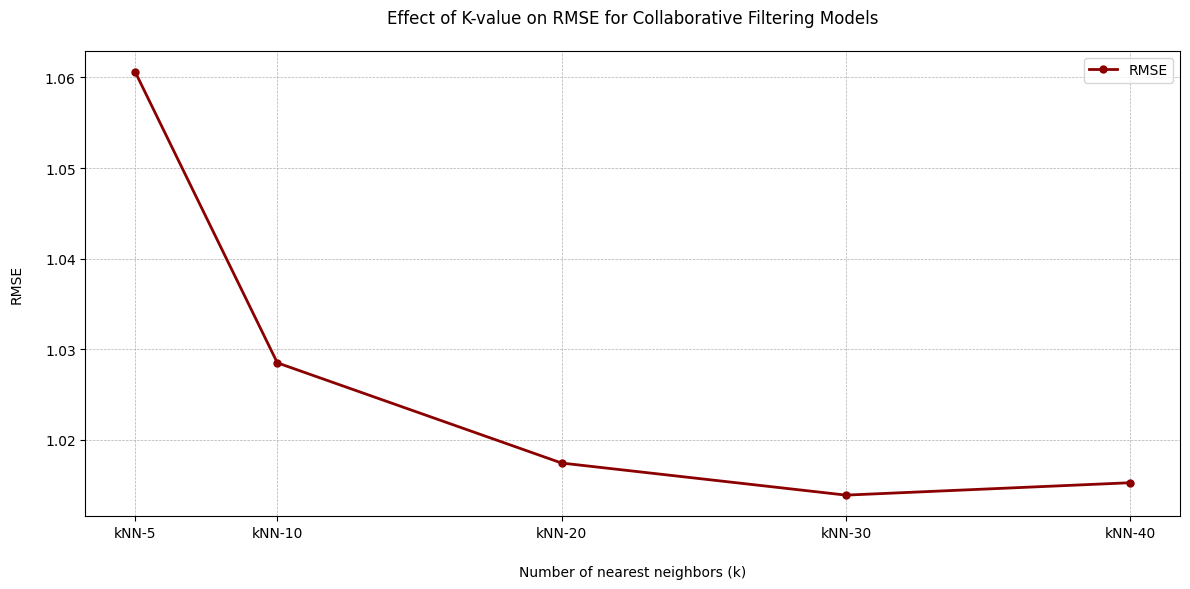

In [35]:
fig, ax = plt.subplots()

k_values = RMSE_CF_df['Model'].str.extract('(\d+)').astype(int)

ax.plot(k_values, RMSE_CF_df.RMSE, label="RMSE", color='darkred', marker='o', markersize=5, linewidth=2)

plt.xlabel("Number of nearest neighbors (k)", labelpad=18)
plt.ylabel("RMSE", labelpad=15)
plt.title("Effect of K-value on RMSE for Collaborative Filtering Models", pad=20)
fig.set_figheight(6)
fig.set_figwidth(12)

plt.xticks(k_values[0], RMSE_CF_df['Model'])  
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

The graph illustrates the impact of the K-value on the performance of collaborative filtering models. The root mean square error (RMSE) decreases as the number of nearest neighbors increases from 5 to 40, indicating improved accuracy. With a K-value of 30, the model achieves its lowest RMSE, suggesting this is the optimal number of neighbors for the best predictive performance among the values tested. Therefore, I'll use the K-value of 30 for the final collaborative filtering model in our hybrid recommender system.

In [36]:
best_model_name = 'kNN-30'
num_neighbours = 30
predictions_kNN_30 = []


for index, row in X_val.iterrows():
    # If the movie is in the training data
    if row["movie_id"] in X_train["movie_id"].unique():
        # Extract all user IDs for users who have rated the movie
        users_rated_movie = X_train.loc[X_train['movie_id'] == row['movie_id'], 'user_id']
        # Sort these users by similarity (Pearson distance)
        users_sorted = pearson_distance.loc[row['user_id'], users_rated_movie].sort_values()
        # Select the nearest neighbours
        nearest_neighbours = users_sorted[:num_neighbours]
        # Extract the nearest neighbours' ratings data
        nn_data = train_df.loc[train_df['user_id'].isin(nearest_neighbours.index.to_list())]
        # Calculate the weighted average of the nearest neighbours' ratings
        nearest_neighbours_avg_rating = np.average(
            nn_data.loc[train_df['movie_id'] == row['movie_id'], 'rating'], axis=0,
            weights=(1/nearest_neighbours))  # Note the change: weights are 1-distance to act as similarity
    else:
        # Fallback prediction, could be the overall average rating or another method
        nearest_neighbours_avg_rating = train_df['rating'].mean()

    # Appending the prediction to the list of predictions
    predictions_kNN_30.append(nearest_neighbours_avg_rating)

print(predictions_kNN_30)

[3.821867119913292, 3.4391391977170773, 2.3643801304741876, 4.268601716302057, 3.7408846278452215, 3.6316321339589175, 3.3901497585060705, 3.633378817209325, 3.842932687574575, 4.231400037269484, 4.331478816192706, 4.0028323998543875, 3.4648730052134584, 3.794359194823191, 3.8044700909481644, 4.532004593725254, 3.0671017674796817, 3.8796480613900535, 2.964752517990374, 2.7726942717651255, 3.7046713321600975, 3.080412927029456, 3.4865609672520517, 3.658419740636217, 3.6305867080913417, 3.4673698184346455, 3.5243342449139043, 4.0, 3.4619274272382317, 3.4017568317654905, 3.910198436660391, 3.7326866846566085, 2.435766437320071, 3.8672086542233512, 3.4993432646487426, 3.577209941613078, 3.871295082683011, 3.0935047328758416, 3.9335757616744873, 3.7869666891896125, 3.1723664570113113, 3.358157405928985, 3.3055283800901263, 3.9550351091994225, 4.288234097561471, 4.230151333126083, 2.2068831674764136, 3.901723859669982, 3.609964070819424, 3.1994674416854507, 4.2864880793494, 4.434420053989751

### <a id="splitting-the-dataset"></a>3.4) Hybrid Recommendation System

In this section, we're going to mix the best parts of content-based filtering (CBF) and collaborative filtering (CF) to make a hybrid recommender system. By doing this, we hope to create a system that's better than either CBF or CF on their own. 

In [43]:
# Extracting the validation prediction from the CBF dataframe containing all predictions
CBF_predictions = []
for index, row in X_val.iterrows():
    user_predictions = CBF_model.loc[row["user_id"], row["movie_id"]]
    CBF_predictions.append(user_predictions)


CF_predictions = predictions_kNN_30  

# Calculating the predictions for the different hybrid "models": different weighted averages of CF and CBF filtering
print("Hybrid (Lasso and kNN-30):")
weighted_avgs = [(0.5, 0.5), (0.45, 0.55), (0.4, 0.6), (0.35, 0.65), (0.3, 0.7), (0.25, 0.75), (0.20, 0.80)]

for weight in weighted_avgs:
    combined_predictions = np.array([y_pred * weight[0] for y_pred in np.array(CBF_predictions)]) + np.array([y_pred * weight[1] for y_pred in np.array(CF_predictions)])
    rmse = sqrt(mean_squared_error(y_val, combined_predictions))
    print(f"RMSE for CBF weighted {weight[0]} and CF weighted {weight[1]}: {rmse}")

Hybrid (Lasso and kNN-30):
RMSE for CBF weighted 0.5 and CF weighted 0.5: 0.9635511902782619
RMSE for CBF weighted 0.45 and CF weighted 0.55: 0.9635827040043898
RMSE for CBF weighted 0.4 and CF weighted 0.6: 0.9647544407784274
RMSE for CBF weighted 0.35 and CF weighted 0.65: 0.9670622559703738
RMSE for CBF weighted 0.3 and CF weighted 0.7: 0.970498044933038
RMSE for CBF weighted 0.25 and CF weighted 0.75: 0.9750498837960638
RMSE for CBF weighted 0.2 and CF weighted 0.8: 0.9807022325548741


## <a id="analysis"></a>4) Test

Finally, Let us check the generalization ability of our best performace combiantion Hybrid Recommendation System. 

In [44]:
# Extracting the test dataset predictions from the CBF model
CBF_test_predictions = []
for index, row in X_test.iterrows():
    user_predictions = CBF_model.loc[row["user_id"], row["movie_id"]]
    CBF_test_predictions.append(user_predictions)

# Generating CF model predictions for the test dataset
CF_test_predictions = []
for index, row in X_test.iterrows():
    if row["movie_id"] in X_train["movie_id"].unique():
        users_rated_movie = X_train.loc[X_train['movie_id'] == row['movie_id'], 'user_id']
        users_sorted = pearson_distance.loc[row['user_id'], users_rated_movie].sort_values()
        nearest_neighbours = users_sorted[:30]  
        nn_data = train_df.loc[train_df['user_id'].isin(nearest_neighbours.index.to_list())]
        nearest_neighbours_avg_rating = np.average(nn_data.loc[nn_data['movie_id'] == row['movie_id'], 'rating'], weights=(1/nearest_neighbours))
    else:
        nearest_neighbours_avg_rating = train_df['rating'].mean()
    CF_test_predictions.append(nearest_neighbours_avg_rating)



In [45]:
print("RMSE Lasso:", sqrt(mean_squared_error(y_test, CBF_test_predictions)))

RMSE Lasso: 1.0360775533980056


In [46]:
print("RMSE KNN_30:", sqrt(mean_squared_error(y_test, CF_test_predictions)))

RMSE KNN_30: 1.013203585616535


In [47]:
weight_CBF = 0.5
weight_CF = 0.5
combined_test_predictions = np.array([y_pred * weight_CBF for y_pred in np.array(CBF_test_predictions)]) + np.array([y_pred * weight_CF for y_pred in np.array(CF_test_predictions)])
# Calculating RMSE for the test data
test_rmse = sqrt(mean_squared_error(y_test, combined_test_predictions))
print("Test RMSE for the best performing Hybrid model:", test_rmse)


Test RMSE for the best performing Hybrid model: 0.9708749046647804


## <a id="analysis"></a>5) Evaluation


The RMSE of Hybrid Recommendation System is 0.971 based on the test data, and the RMSE of the baseline model is 1.000. So there has a substantial improvement for Hybrid Recommendation System, in terms of RMSE, after combining CF and CBF in a proper rate.

There are still have some points that we can improve. 


1. Feature Engineering : we can add the average age of movie fan to the movies dataset. Movies are made for specific audiences. After analyzing the data in section 1.1, it seems that audiences vary in age, but not as widely as the overall population. There's a chance that a movie's ratings could be linked to the average age of its typical viewers, especially for genres aimed at kids or teens. Yet, even movies targeted at a specific group may attract a broader range of viewers who also give ratings. we want to check if knowing the average age of users who give high ratings to movies can help make better recommendations. 

2. Model Complexity: While the models chosen are appropriate, exploring more complex or recent recommendation system approaches, such as matrix factorization techniques or deep learning models, could offer interesting comparisons.

3. Evaluation Metrics: Beyond RMSE, consider using additional metrics like precision, recall, or F1-score, which can provide a more nuanced view of the model's recommendation quality, especially in terms of user satisfaction.

In the future, we aim to embed the recommendation system into a website, adjusting the model based on the actual behavior of real users, rather than just relying on the numerical results of metrics.